In [1]:
%load_ext autoreload
%autoreload 2
import spacy
import scispacy
from scispacy.linking import EntityLinker
import en_core_sci_lg
from scify.nlp import *
from scify.V import V


In [2]:
text = "Spinal and bulbar muscular atrophy (SBMA) is an inherited motor neuron disease caused by the expansion of a polyglutamine tract within the androgen receptor (AR). SBMA can be caused by this easily."

In [3]:
from scispacy.abbreviation import AbbreviationDetector
from spacy.pipeline import merge_entities
from scispacy.linking import EntityLinker

nlp = load_sci_pipe()

In [4]:
#linker_umls = EntityLinker(resolve_abbreviations=True, name="umls")
#nlp.add_pipe(linker_umls)

In [5]:
from textacy.corpus import Corpus
from scify.consts import labels
from spacy.tokens import Doc, Token, Span

for label in labels:
    nlp.vocab.strings.add(label)

reannotate()

#https://github.com/explosion/spaCy/issues/860
#doc = nlp(text)

In [6]:
from scify.utils.datasets import get_csv

dep_paths = get_csv("../data/experiments/GNBR_chem_gene_good_patterns_20k.csv")

In [7]:
dep_paths[1]

{'dep_path': 'enhances|nsubj|start_entity enhances|nmod|up-regulation up-regulation|nmod|end_entity',
 'occurence_count': '1'}

In [8]:
deps = sorted(dep_paths, key=lambda obj: int(obj["occurence_count"]), reverse=True)

In [9]:
deps[:3]

[{'dep_path': 'domain|compound|start_entity domain|nmod|end_entity',
  'occurence_count': '157'},
 {'dep_path': 'inhibitor|appos|start_entity inhibitor|compound|end_entity',
  'occurence_count': '155'},
 {'dep_path': 'fingers|compound|start_entity fingers|nmod|end_entity',
  'occurence_count': '117'}]

## TODO
[] Only keep matches that link desired entities \ (annotated ... -> )
[] Think hard about DataTypes or Classes for the whole Library (eg. Annotation, Match, MatchContext, )
[] 

## Get Most Potent Paths


## Apply to GNBR itself and check Syntactic Parsing accuracy of SciSpacy

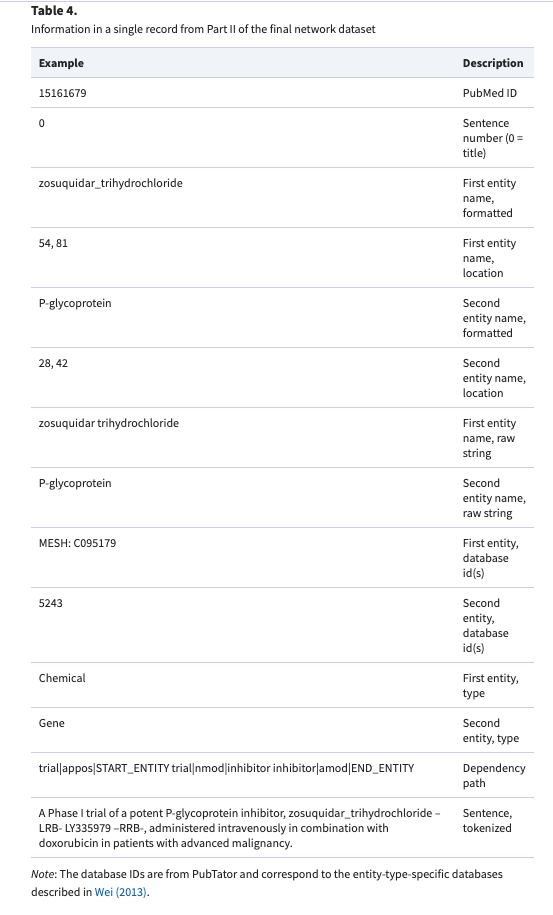

In [10]:
from IPython.display import Image
Image('../assets/GNBR_datafile_info.png')

## Precision on GNBR
Should be high since the clusters are annotated by humans ... the syntax parsing might make troubles

In [ ]:
from scify.utils.datasets import GNBR
data, distributions = GNBR.get_data_and_distributions("../DATA/biomedrel/")

In [62]:
"aa" not in ["aaaa", "bb"] and "aa" not in {"asa", "sss"}

True

In [65]:
'inhibitor|appos|start_entity inhibitor|compound|end_entity'.split(" ")

['inhibitor|appos|start_entity', 'inhibitor|compound|end_entity']

In [77]:
from pydash import flatten
from scify.consts import SPACY_DEPS
def fixed_terms_in_dep_path(dep_path):
    return flatten([p for part in dep_path.split(" ") for p in part.split("|")  
                    if str.lower(p) not in ["start_entity", "end_entity"] and str.lower(p) not in SPACY_DEPS])

In [78]:
fixed_terms_in_dep_path('inhibitor|appos|start_entity inhibitor|compound|end_entity')

['inhibitor', 'inhibitor']

In [ ]:
ex = {'levels|nmod|start_entity levels|compound|end_entity': [{'doc_idx': 490,
   'span': 'expression level of IRS-1',
   'sents': [LPS+PA treatment group significantly decreases the relative expression level of IRS-1, PI3K, AKT, phosphorylation of AKT, TLR-4, MyD88, phosphorylation of IKKα, NF-κB, Bcl-2 and increases the relative expression level of Bax, cleaved caspase 3 and cleaved caspase 8, compared with the cells treated with NAFLD model.],
   'matches': [[8, 10, 7], [36, 38, 35]]}

In [79]:
d = nlp("LPS+PA treatment group significantly decreases the relative expression level of IRS-1, PI3K, AKT, phosphorylation of AKT, TLR-4, MyD88, phosphorylation of IKKα, NF-κB, Bcl-2 and increases the relative expression level of Bax, cleaved caspase 3 and cleaved caspase 8, compared with the cells treated with NAFLD model.")

In [81]:
p = 'levels|nmod|start_entity levels|compound|end_entity'
subtrees =[[8, 10, 7], [36, 38, 35]]

In [ ]:
 'rate|nmod|start_entity rate|compound|end_entity': [{'doc_idx': 490,
   'span': 'apoptosis rate and expression of apoptotic proteins in AML cells',
   'sents': [Moreover, siNR4A1 was utilized to knockdown NR4A1 expression, and leptomycin B (LMB) was adopted to inhibit the nuclear export; afterwards, the apoptosis rate and expression of apoptotic proteins in AML cells were detected.],
   'matches': [[26, 32, 25]],

In [114]:
reannotate()
fixed_terms_in_dep_path(p),
Token.set_extension('annotated', default=[], force=True)
[e._.annotated for e in get_entities_from_match(pm[490], [26, 32, 25], 'rate|nmod|start_entity rate|compound|end_entity')]
#TODO filter then if only the entities are there
#otherwise fix construct_pattern ... but the permutation space of checking all possible lists blows up

[[], [], []]

In [101]:
[e._.annotated for e in pm[490] if e.]

AttributeError: 'spacy.tokens.token.Token' object has no attribute 'label'

In [90]:
set(['levels', 'levels']).symmetric_difference(['level', 'IRS-1', 'expression'])

{'IRS-1', 'expression', 'level', 'levels'}

In [91]:
def sentences_w_entities(docs, ent_a:List[str], ent_b:List[str]):
    docz = [doc for doc in docs if doc_has_entity_labels(doc,  [ent_a, ent_b])]
    return [sent for doc in docz for sent in doc.sents if doc_has_entity_labels(sent,  [["CHEMICAL", "SIMPLE_CHEMICAL"], ["GENE", "GENE_OR_GENE_PRODUCT"]])]


def get_range(coll):
    return (min(coll), max(coll))

#chem-gene or gene-chem
def get_entities_from_match(doc, subtree, dep_path):
    """This assumes that the Entities are the terms you can't find in dep_path (because there they are ..|start_ent |end_ent)"""
    
    match_terms = [doc[i] for i in subtree]
    return match_terms
    
    


def match_links_entities(doc, subtree, start_entity=["CHEMICAL", "SIMPLE_CHEMICAL"], end_entity=["GENE", "GENE_OR_GENE_PRODUCT"])->bool:
    """checks if match is a wanted pair. TODO: let construct_pattern handle this from the start
    subtree ~ [0, 5, 8, ...] (tokenIdx)
    """
    #basically the two variables (start_ent, end_ent) because the rest must match per Pattern definition (for now)
    

from typing import Tuple
def theme_support(dep_path, dist:Dict)->List[Tuple]:
    """get non-null GNBR supports for a given dependency path (needs distributions)"""
    supports = dist[dep_path].items()
    return [(a,b) for a,b in supports if b>0]

In [50]:
#gnbr_500 = Corpus(nlp).load(nlp, "../data/experiments/GNBR_chem-gene_annotated_500")
pm = Corpus(nlp).load(nlp, "../data/experiments/pubmed_20n1015_annotated_756")


target_sents = sentences_w_entities(pm, ["CHEMICAL", "SIMPLE_CHEMICAL"], ["GENE", "GENE_OR_GENE_PRODUCT"])
ents_w_candidates(target_sents[1])

[(Results, []),
 (decrease, []),
 (hemoglobin, ['CHEBI', 'GENE_OR_GENE_PRODUCT', 'PROTEIN']),
 (surgery, []),
 (TXA, ['CHEMICAL', 'GENE_OR_GENE_PRODUCT']),
 (group, []),
 (control, []),
 (PRP, ['PROTEIN']),
 (groups, [])]

In [56]:
#first 10000 patterns give 237 hits for 756 pubmed abstract on chemical-> gene ... meh

In [54]:
example = [
    "prevented|nsubj|START_ENTITY prevented|dobj|END_ENTITY",
    "causes|nsubj|START_ENTITY causes|dobj|END_ENTITY"
]
patterns = [dep["dep_path"] for dep in deps[:10000]]
patterns

matcher = add_matches(nlp.vocab, patterns, start_ents=["CHEMICAL", "SIMPLE_CHEMICAL"], end_ents=["GENE", "GENE_OR_GENE_PRODUCT"])
matched_sents = match_texts(matcher, [nlp(ts.text) for ts in target_sents] ,nlp)



#matched_sents

#[V.subtrees(nlp(info["sents"][0].text), info["matches"]) for k in matched_sents for info in matched_sents[k]]
len(matched_sents)

error with pattern levels|nmod|start_entity correlated|nmod|levels correlated|nsubj|levels levels|nmod|end_entity --> None


237

In [72]:
matched_sents

{'combination|nmod|start_entity combination|nmod|end_entity': [{'doc_idx': 490,
   'span': 'combination with TXA',
   'sents': [TXA was applied in 23 patients, PRP in 20, and PRP in combination with TXA in 20.],
   'matches': [[14, 16, 16]],
   'sent_ents': [[TXA, patients, PRP, PRP, combination, TXA]]},
  {'doc_idx': 490,
   'span': 'combination of thereof drugs',
   'sents': [Between the 8th and 14th day, rats were treated with water, Li, FA or a combination of thereof drugs (Li + FA).],
   'matches': [[17, 20, 20]],
   'sent_ents': [[day,
     rats,
     treated with,
     water,
     Li,
     FA,
     combination,
     drugs,
     Li ,
     FA]]}],
 'group|compound|start_entity group|compound|end_entity': [{'doc_idx': 490,
   'span': 'TXA group',
   'sents': [Results
    There was a difference (p <0.01) in the decrease in hemoglobin 48 hours after surgery between the TXA group and the control and PRP groups.],
   'matches': [[23, 22, 22], [29, 28, 28]],
   'sent_ents': [[Results,
 

### What pattern yields most on PubMed? On GNBR_500 (might be sorted...and skewed sentences)

## Precision on PubMed
Get pubmed sentences with Chem-Gene pairs (500 in the 750 abstracts) and see if there's some matches with the top dep patterns from GNBR

In [ ]:
#TODO check if theme support among paths is evenly distributed

In [ ]:
#invalid pattern
construct_pattern('causes|nsubj|END_ENTITY causes|dobj|START_ENTITY')